# 日経平均株価 週足 メディアン統計

In [35]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [36]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

In [37]:
code = 'N225'
symbol = '^%s' % code
ticker = yf.Ticker(symbol)

In [38]:
# 週足で過去 5 年分のデータを取得
df0 = ticker.history(period='10y', interval='1wk')

# ローソク足のチャートには、そのうち過去 3 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_3y =  datetime.timedelta(days=365 * 3)
df = df0[df0.index >= dt_last - tdelta_3y]

## Moving Median

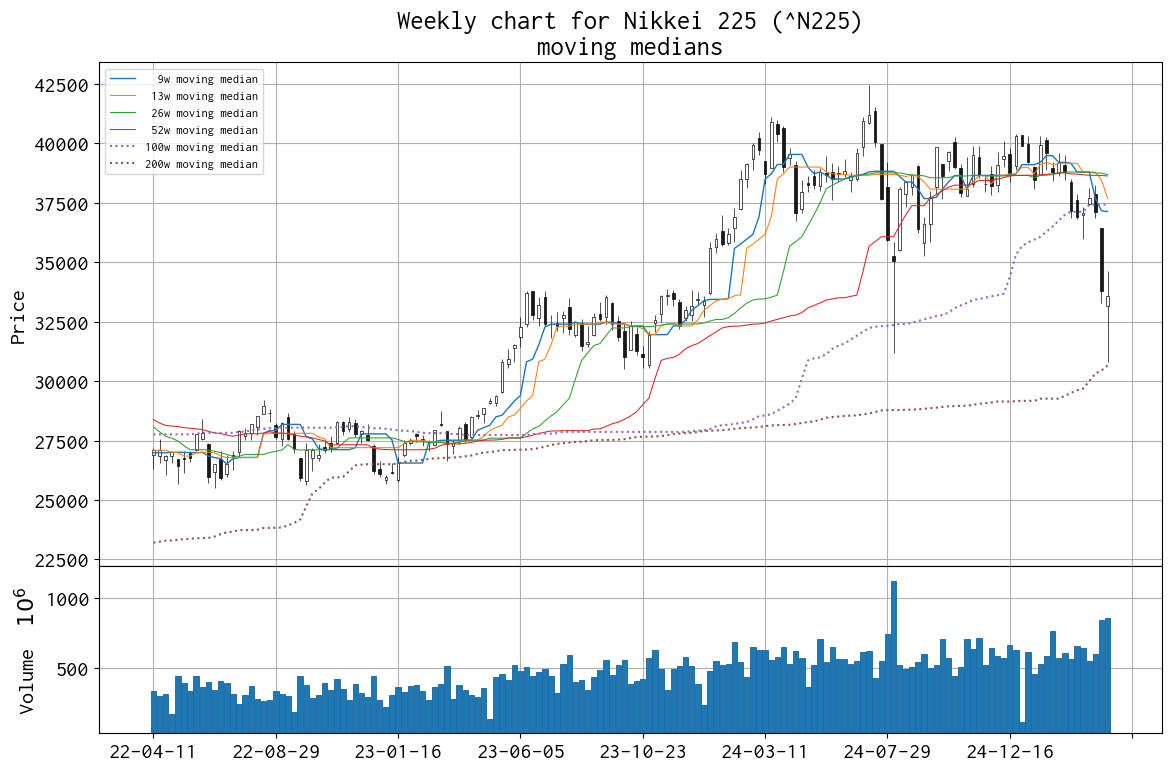

In [39]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm09 = df0['Close'].rolling(9).median()
mm13 = df0['Close'].rolling(13).median()
mm26 = df0['Close'].rolling(26).median()
mm52 = df0['Close'].rolling(52).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm09[df.index], width=1, label='  9w moving median', ax=ax[0]),
    mpf.make_addplot(mm13[df.index], width=0.75, label=' 13w moving median', ax=ax[0]),
    mpf.make_addplot(mm26[df.index], width=0.75, label=' 26w moving median', ax=ax[0]),
    mpf.make_addplot(mm52[df.index], width=0.75, label=' 52w moving median', ax=ax[0]),
    mpf.make_addplot(mm100[df.index], width=1.5, linestyle='dotted', label='100w moving median', ax=ax[0]),
    mpf.make_addplot(mm200[df.index], width=1.5, linestyle='dotted', label='200w moving median', ax=ax[0]),
]   

mpf.plot(df, type='candle', style='default', volume=ax[1], datetime_format='%y-%m-%d', addplot=apds, xrotation=0, ax=ax[0])

ax[0].set_title('Weekly chart for %s (%s)\nmoving medians' %(ticker.info['longName'], symbol))
ax[0].legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('report_weekly_chart_median_%s.png' % code)
plt.show()

In [40]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-31 00:00:00+09:00,36440.179688,36440.179688,33259.761719,33780.578125,844100000,0.0,0.0
2025-04-07 00:00:00+09:00,33154.968750,34639.390625,30792.740234,33585.578125,859500000,0.0,0.0


In [41]:
df.tail(2)['Close']

Date
2025-03-31 00:00:00+09:00    33780.578125
2025-04-07 00:00:00+09:00    33585.578125
Name: Close, dtype: float64

In [42]:
df.tail(2)['Close'].diff()

Date
2025-03-31 00:00:00+09:00      NaN
2025-04-07 00:00:00+09:00   -195.0
Name: Close, dtype: float64

In [43]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-04-07 00:00:00+09:00    430.609375
dtype: float64

In [44]:
df['Close'].rolling(9).median().tail(5)

Date
2025-03-10 00:00:00+09:00    38776.941406
2025-03-17 00:00:00+09:00    38776.941406
2025-03-24 00:00:00+09:00    37677.058594
2025-03-31 00:00:00+09:00    37155.500000
2025-04-07 00:00:00+09:00    37120.328125
Name: Close, dtype: float64

In [45]:
df['Close'].rolling(13).median().tail(5)

Date
2025-03-10 00:00:00+09:00    38787.019531
2025-03-17 00:00:00+09:00    38787.019531
2025-03-24 00:00:00+09:00    38776.941406
2025-03-31 00:00:00+09:00    38451.460938
2025-04-07 00:00:00+09:00    37677.058594
Name: Close, dtype: float64

In [46]:
df['Close'].rolling(26).median().tail(5)

Date
2025-03-10 00:00:00+09:00    38781.980469
2025-03-17 00:00:00+09:00    38781.980469
2025-03-24 00:00:00+09:00    38739.419922
2025-03-31 00:00:00+09:00    38739.419922
2025-04-07 00:00:00+09:00    38672.404297
Name: Close, dtype: float64

In [47]:
df['Close'].rolling(52).median().tail(5)

Date
2025-03-10 00:00:00+09:00    38665.839844
2025-03-17 00:00:00+09:00    38646.929688
2025-03-24 00:00:00+09:00    38644.509766
2025-03-31 00:00:00+09:00    38639.265625
2025-04-07 00:00:00+09:00    38616.044922
Name: Close, dtype: float64

In [48]:
df0['Close'].rolling(100).median().tail(5)

Date
2025-03-10 00:00:00+09:00    37111.925781
2025-03-17 00:00:00+09:00    37411.455078
2025-03-24 00:00:00+09:00    37411.455078
2025-03-31 00:00:00+09:00    37411.455078
2025-04-07 00:00:00+09:00    37411.455078
Name: Close, dtype: float64

In [49]:
df0['Close'].rolling(200).median().tail(5)

Date
2025-03-10 00:00:00+09:00    29678.719727
2025-03-17 00:00:00+09:00    29997.339844
2025-03-24 00:00:00+09:00    30315.325195
2025-03-31 00:00:00+09:00    30440.945312
2025-04-07 00:00:00+09:00    30654.200195
Name: Close, dtype: float64

## Robust Bollinger bands

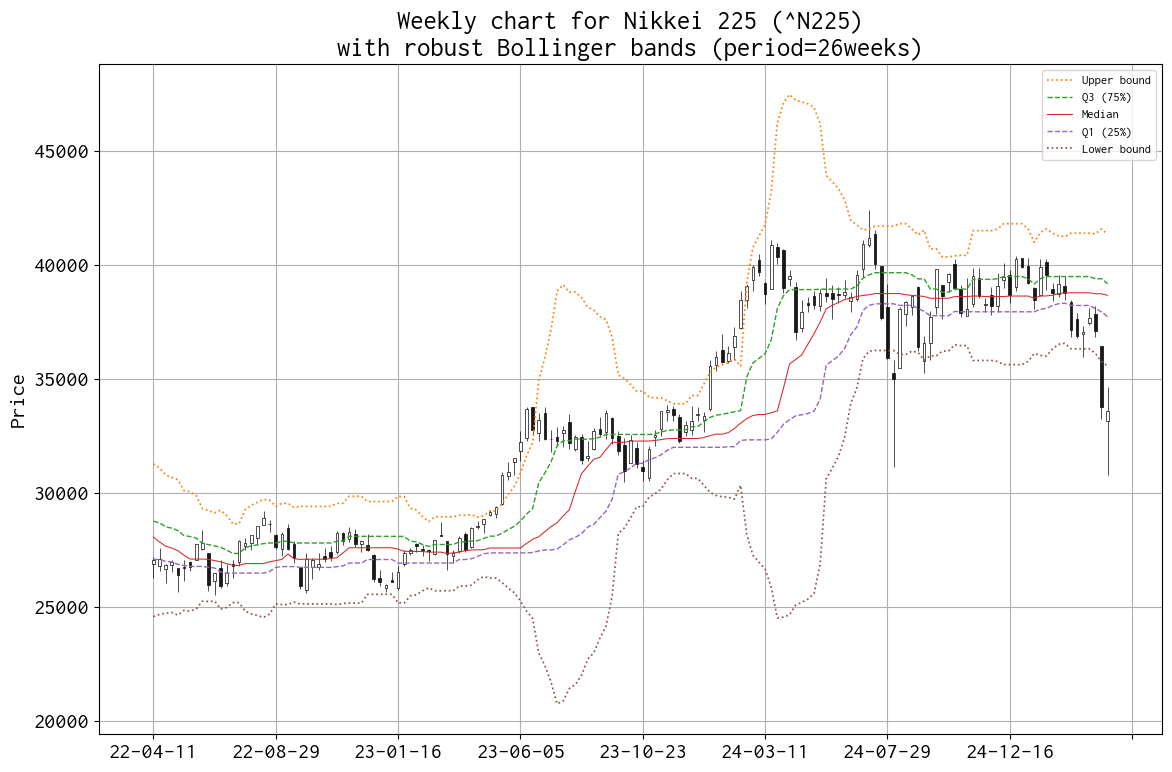

In [50]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 26
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]

mpf.plot(df, type='candle', style='default', addplot=apds, datetime_format='%y-%m-%d', xrotation=0, ax=ax)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Weekly chart for %s (%s)\nwith robust Bollinger bands (period=%dweeks)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Weekly chart for %s\nwith robust Bollinger bands (period=%sweeks)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_weekly_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラムと Q-Q プロット

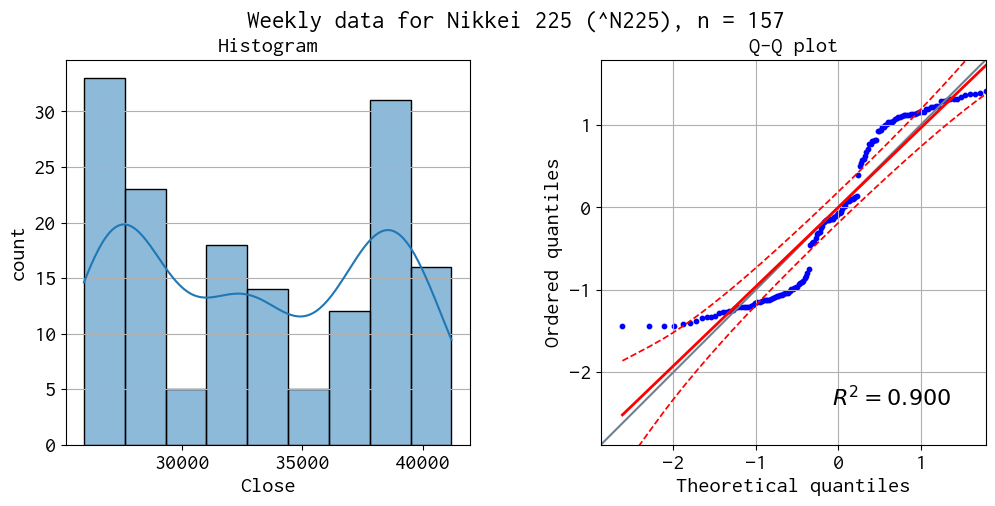

In [51]:
plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Weekly data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_weekly_histogram_qqplot_%s.png' % code)
plt.show()